# Local resolution estimation with the one-image FRC

This notebook shows how Quoll's tools can be used to calculate the one-image FRC. The one-image FRC measure implemented here is a modification of [miplib](https://github.com/sakoho81/miplib). The one-image FRC calculation is calibrated to match the gold standard two-image FRC using a calibration function, which is derived here for EM images. The original `miplib` calibration function was calculated for fluorescence microscopy.

In [12]:
import os
import matplotlib.pyplot as plt
import tifffile
import numpy as np

from quoll.io import reader
from quoll.frc import oneimg

## Choose an image to load

Load an image as a Quoll Image object, this contains the attributes needed to calculate FRC and other image quality measures.

In [2]:
QuollImg = reader.Image(
    filename="../data/SerialFIB57_2048x2048.tif",
    pixel_size=3.3724,
    unit="nm"
)

A Quoll Image object contains the following attributes
- `filename`
- `pixel_size`: size of each pixel in physical units
- `unit`: unit of measurement for pixel size
- `tiles`: a dictionary, where the keys are the path to each tile and the values are the tile as an array
- `img_data`: image as an array
- `img_dims`: dimensions of the image in (z,x,y)
- `img_bitdepth`: bit depth of the image.

Any of the Quoll Image attributes can be called using the following cell

In [3]:
# Just change out the attribute you want to retrieve
QuollImg.pixel_size

3.3724

The image can also be displayed with the `Image.show` method

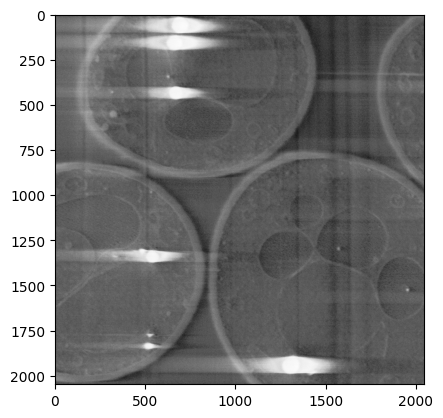

In [4]:
QuollImg.show()

## Calculating local FRC

The function `oneimg.calc_local_frc` returns a Pandas DataFrame of the local resolution of each patch of an image.

This function requires the following inputs:
- `Image`: a Quoll Image object
- `tile_size`: length of one side of the square tile in pixels. This must be above 100. A good default is usually 256.
- `tiles_dir`: path to the directory where you will save the tiles.

By default, no calibration function is applied so you should only use the resolution values as relative comparisons rather than absolute values

In [5]:
results_df = oneimg.calc_local_frc(
    Image=QuollImg,
    tile_size=256,
    tiles_dir="./test_tiles_dir"
)

results_df

100%|███████████████████████████████████████████| 64/64 [00:01<00:00, 46.96it/s]


,Resolution
0,10.520249
1,13.585120
2,9.504429
3,9.810074
4,10.590218
...,...
59,10.277504
60,10.529572
61,9.755191
62,11.025858


We can now make use of the resolutions data. One example is to just describe the distributions.

In [6]:
results_df.Resolution.describe()

count    64.000000
mean     10.636055
std       1.128329
min       8.144214
25%       9.845020
50%      10.595704
75%      11.300072
max      13.952879
Name: Resolution, dtype: float64

We can also plot the resolutions

Text(0, 0.5, 'Number of patches')

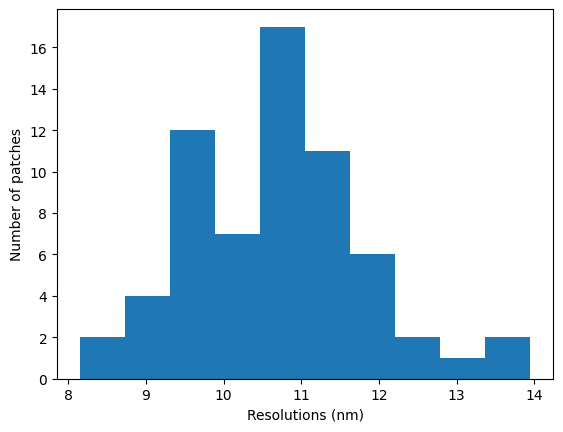

In [7]:
plt.hist(results_df.Resolution)
plt.xlabel("Resolutions (nm)")
plt.ylabel("Number of patches")

Or plot a heatmap of the resolutions

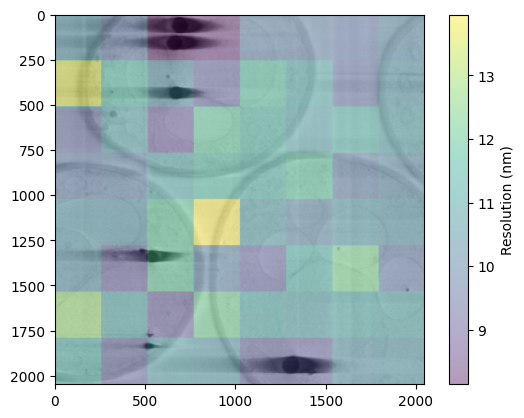

In [8]:
resolution_heatmap = oneimg.plot_resolution_heatmap(
    Image=QuollImg,
    results_df=results_df
)

# plot the heatmap over the original image

plt.figure()
plt.imshow(QuollImg.img_data, cmap="Greys_r")
plt.imshow(resolution_heatmap, cmap="viridis", alpha=0.4)
plt.colorbar(label=f"Resolution ({QuollImg.unit})")

The resolution heatmaps can also be saved separately as tiff files

In [13]:
output_fname = "test_heatmap.tif"  # edit as required

tifffile.imwrite(
    output_fname,
    resolution_heatmap.astype("uint8"),
)

## Defining custom calibration functions

Calibration functions map the resolution values measured by the local FRC from subsampled images to absolute resolution values obtained from calibration data. More details are available in the Okapi-EM and original Koho et al. papers.

Briefly, calibration data is acquired at a range of pixel sizes where two images are acquired of the same FOV, and the "official" FRC resolution is calculated from these pairs of images. The function mapping the "official" two-image FRC to the one-image subsampled FRC is known as the calibration function. 


In [17]:
def calibration_func(frequencies: list) -> list:
    """Test calibration function (the one used in miplib)
    
    Args:
        frequences (list): x-values in the FRC curve for subsampled image
        
    Returns:
        list: x-values in FRC curve after calibration to match two-image FRC
    """
    
    correction = 0.95988146 * np.exp(13.90441896 * (np.array(frequencies) - 0.97979108)) + 0.55146136
    corrected_frequencies = frequencies / correction
    return corrected_frequencies

cal_results_df = oneimg.calc_local_frc(
    Image=QuollImg,
    tile_size=256,
    calibration_func=calibration_func
)

cal_results_df.describe()

100%|███████████████████████████████████████████| 64/64 [00:01<00:00, 48.36it/s]


,Resolution
count,48.000000
mean,6.203129
std,0.497716
min,5.519749
25%,5.877806
50%,6.151050
75%,6.448786
max,7.683633


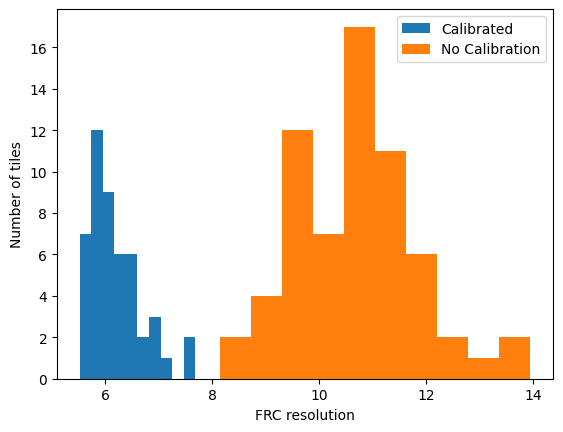

In [25]:
plt.figure()
plt.hist(cal_results_df.Resolution, label="Calibrated")
plt.hist(results_df.Resolution, label="No Calibration")
plt.ylabel("Number of tiles")
plt.xlabel("FRC resolution")
plt.legend()